In [23]:
# use Python 3.10.9

import shapely as sp
from shapely import geometry, ops, wkt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
#from shapely.geometry.polygon import Polygon
from shapely.ops import polygonize, polygonize_full 
#========================
import numpy as np
import pandas as pd
from descartes import PolygonPatch
from colour import Color
import latex 

#========================
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#========================
##preferences
np.set_printoptions(precision=3)

In [1]:
# importing channel and log objects
# the functions imported MUST be in a .py file

from mc3_stations_channel_practice1 import channel_points
from mc3_stations_log1_practice import log1_points 

#print(channel_points)
#print(log1_points)

[('0.159776', '1000.505626'), ('0.570111', '1000.502426'), ('1.46', '1000.4965'), ('3.234', '1000.4653'), ('6.9468', '1000.4677'), ('8.759', '1000.6287'), ('9.3156', '1000.6407'), ('9.7678', '1000.6197'), ('10.153868', '1000.5997'), ('10.946', '1000.498'), ('11.20388', '1000.3488'), ('11.271', '1000.229'), ('11.4744', '999.969226'), ('11.916', '999.541726'), ('12.045', '999.4175'), ('12.76776', '999.3758'), ('13.74', '999.3527'), ('14.51', '999.4714'), ('15.505', '999.547'), ('16.789', '999.6338'), ('17.69129', '999.566'), ('18.604', '999.635'), ('18.83037', '999.7988'), ('18.94295', '999.830126'), ('20.039', '999.902626'), ('21.5955', '1000.1668'), ('22.6236', '1000.341226'), ('23.22854', '1000.442626'), ('24.01677', '1000.461426'), ('25.6412', '1000.437726'), ('27.006899', '1000.417926'), ('27.865588', '1000.405326'), ('28.520322', '1000.3719'), ('30.26438', '1000.2695'), ('32.37156', '1000.2503'), ('33.4509', '1000.3469'), ('36.6368', '1000.758126')]
[('15.2966', '1001.758226'), ('1

In [25]:
def plot_metrics(x):
   ## CHANNEL AND WATER SURFACE
    numeric_channel = [(float(x), float(y)) for x, y in channel_points] #converts a list of tuples containing string values to a list of numeric pairs
    channel = LineString(numeric_channel)
    wse = x # water surface elevation. Data obtained from sensors (m)
    wse_start = channel.bounds[0] # where the WSE line BEGINS being drawn. Min X minus one more
    wse_end = channel.bounds[2] # where the WSE line ENDS being drawn. Max X plus one more
    wse_line = LineString([(wse_start, wse),(wse_end, wse)]) # a list of points that becomes a line
    channel_invert = channel.bounds[1] # the lowest elevation of the channel
    
    ## FINDING THE SECOND HIGHEST CHANNEL ELEVATION
    # Necessary because we need to limit water surface elevations to those that can be bound by the channel data; otherwise we'll have geometry issues.
    channel_maxy_right = -9000 # the highest elevation to the RIGHT of the thalweg (if your xsection looks downstream).
    for point in channel.coords: # For each of the points in the 'channel' linestring:
        if point[0] > channel.bounds[1]: # if the coordinate is to the RIGHT of the channel invert
            if point[1] > channel_maxy_right: # and if the next coordinate has a higher y-value than the current highest point:
                channel_maxy_right = point[1] # then give channel_maxy_right that value.

    channel_maxy_left = -9000 # the highest elevation to the LEFT of the thalweg (if your xsection looks downstream).
    for point in channel.coords: # For each of the points in the 'channel' linestring:
        if point[0] < channel.bounds[1]: # if the coordinate is to the LEFT of the channel invert
            if point[1] > channel_maxy_left: # and if the next coordinate has a higher y-value than the current highest point:
                channel_maxy_left = point[1] # then give channel_maxy_left that value.

    wse_max = min(channel_maxy_right, channel_maxy_left) # the maximum considered water surface elevation is the lower of these two values.

    ## CREATE A PLOT
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(*channel.xy, color="black", lw=2)
    ax.plot(*wse_line.xy, color="blue", alpha=0)
    ax.set_aspect('equal', adjustable='box') # or, plt.axis('scaled')

    # INTERMEDIATE PRODUCTS TO GET THE FLOW EXTENTS
    waterpoly = Polygon([(wse_start, wse),(wse_end, wse), (wse_end ,channel_invert), (wse_start, channel_invert)]) # intermediate product. a rectangle that will get stamped out by the channel geometry to get the flow extents shape
    waterpolypatch = PolygonPatch(waterpoly, alpha = .15)
    channelpoly = Polygon(channel) # . intermediate product. CREATING A CHANNEL POLGYON FOR INTERSECTION WITH WSE POLGYON
    channelpolypatch = PolygonPatch(channelpoly, alpha = .10, color = 'brown')

    # FLOW EXTENTS (BOUNDARY)
    flow_extent = waterpoly.intersection(channelpoly) # flow area geometry
    flow_extent_patch = PolygonPatch(flow_extent, fc='#C1F0F6', alpha=0.5)
    ax.add_artist(flow_extent_patch)

    # LARGE WOOD OBJECTS
    numeric_log1 = [(float(x), float(y) - 0.4) for x, y in log1_points] #converts a list of tuples containing string values to a lis of numeric pairs
    log1_points2 = LineString(numeric_log1)
    log1 = Polygon(log1_points2)
    objects_combined = [log1] # separated by commas combining all of the objects
    objects_multipoly = MultiPolygon(objects_combined) # LOG POLYGONS COMBINED TO MULTIGON
    # Formatting display:
    objects_multipoly_patch = PolygonPatch(objects_multipoly, facecolor='#553c00', edgecolor='#553c00', hatch='////', lw=2)
    facecolor_with_alpha = objects_multipoly_patch.get_facecolor()
    facecolor_with_alpha = (*facecolor_with_alpha[:3], 0.11) # set the alpha value (opacity)
    objects_multipoly_patch.set_facecolor(facecolor_with_alpha)
    ax.add_artist(objects_multipoly_patch)

    # FLOW BETWEEN THE WOOD
    flow_interstitial = flow_extent.difference(objects_multipoly) # FLOW AREA AROUND WOOD
    fa_wood_patch = PolygonPatch(flow_interstitial, fc='#00FFFF', alpha=0.25, lw=0)
    ax.add_artist(fa_wood_patch)
    flow_area_interstitial = flow_interstitial.area # flow area around LW

    # SUBMERGED WOOD
    wood_sub = flow_extent.difference(flow_interstitial) # the geometry of the submerged wood
    wood_sub_patch = PolygonPatch(wood_sub, fc=(1,0.2,0.2,.9), ec=(0,0,0,0))
    ax.add_artist(wood_sub_patch)
    wood_sub_area = wood_sub.area # frontal area of submerged wood

    # WETTED WIDTH
    flow_area_xmin = flow_extent.bounds[0] # get xmin bounds of flow area
    flow_area_xmax = flow_extent.bounds[2] # get xmax bounds of flow area
    wetted_width = flow_area_xmax - flow_area_xmin # wetted width [m]
    flow_extent_surface = LineString([(flow_area_xmin, wse),(flow_area_xmax,wse)]) # a linestring geometry representing the plane of the water surface to its extents

    flow_extent_perimeter = flow_extent.length # total perimeter of water
    wp_channel = flow_extent_perimeter - wetted_width ## WETTED PERIMETER OF CHANNEL
    flow_interstitial_perimeter = flow_interstitial.length ## total perimeter of water (with wood)

    # WOOD TOPS (intermediate product)
    flow_area_boundary = flow_extent.boundary # extracting the lines of flow_extent
    wood_sub_boundary = wood_sub.boundary # extracting the lines of wood_sub
    wood_tops2 = flow_area_boundary.intersection(wood_sub_boundary) # linestring geometry of where the water surface is interpolated through the wood (erroneous)
    wood_tops = wood_tops2.length # the length of this erroneous surface

    # WETTED PERIMETER
    wp_wood = wood_sub.length - wood_tops # the actual wetted perimeter of the wood
    wp_total = wp_channel + wp_wood # WP TOTAL: wetted LW + wetted channel
    water_surface_length = wetted_width - wood_tops # the cross-sectional length of the actual water surface

    # HYDRAULIC RADIUS
    hydraulic_radius_channel = flow_interstitial.area / wp_channel # Rh: The ratio of the cross-sectional flow area to the cross-sectional wetted perimeter, orthogonal to flow.
    hydraulic_radius_total = flow_interstitial.area / wp_total # Rh: The ratio of the cross-sectional flow area to the cross-sectional wetted perimeter, orthogonal to flow.

    # DIMENSIONLESS METRICS
    porosity = flow_area_interstitial / flow_extent.area # POROSITY (actual flow area divided by flow extent area)
    blockage_ratio = wood_sub_area / flow_extent.area # BLOCKAGE RATIO (Frontal area of wood divided by flow extent area)
    
    
    def conveyance_ratio(flow_area_interstitial, wood_sub_area):
        return flow_area_interstitial / wood_sub_area if wood_sub_area else 0 # should be 'nan' not 0 but this is a workaround
    
    #conveyance_ratio =  conveyance_ratio() # CONVEYANCE RATIO (actual flow area over frontal area of LW)

    def print_final():
        fa_wood_str = str(round(flow_area_interstitial, 2))
        fa_wood_print = "Flow area = " + fa_wood_str + " m\u00b2"
        
        wood_sub_area_str = str(round(wood_sub_area, 2))
        wood_sub_area_print = "Obstructed area = " + wood_sub_area_str + " m\u00b2"

        wettedwidth_str = str(round(wetted_width, 2))
        wettedwidth_print = "Wetted width = " + wettedwidth_str + " m"

        wp_channel_str = str(round(wp_channel, 2))
        wp_channel_print = "$WP_{channel}$ = " + wp_channel_str + " m"

        wp_wood_str = str(round(wp_wood, 2))
        wp_wood_print = "$WP_{wood}$ = " + wp_wood_str + " m"

        wp_total_str = str(round(wp_total, 2))
        wp_total_print = "$WP_{total}$ = " + wp_total_str + " m"

        Rh_tot_str = str(round(hydraulic_radius_total, 2))
        Rh_tot_print = "$R_{h}$, with wood = "+ Rh_tot_str + " m"

        Rh_channel_str = str(round(hydraulic_radius_channel, 2))
        Rh_channel_print = "$R_{h}$, without wood = "+ Rh_channel_str + " m"

        por_str = str(round(porosity, 2))
        por_print = "Porosity ($\phi$) = " + por_str

        
        #def conv_print_function():
        #    global conveyance_ratio
        #    if conveyance_ratio() > 0: return str(round(conveyance_ratio(), 2))
        #    else: return str(0)
        #conv_str = conv_print_function

        conv_str = str(round(conveyance_ratio(flow_area_interstitial, wood_sub_area), 2))
        conv_print = "Conveyance ratio (e) = " + conv_str

        blockage_str = str((round(blockage_ratio, 2)))
        blockage_print = 'Blockage ratio (B) = ' + blockage_str

        return ("==================" + '\n' +
                fa_wood_print + " " + '\n' +
                wood_sub_area_print + " " + '\n' +
                wettedwidth_print  + " " + '\n' +
                "------------------" + " " + '\n' +
                wp_channel_print + " " + '\n' +
                wp_wood_print + " " + '\n' +
                wp_total_print + " " + '\n' +
                Rh_tot_print + " " + '\n' +
                Rh_channel_print + " " + '\n' +
                "------------------" + " " + '\n' + 
                por_print + " " + '\n' +
                blockage_print + " " + '\n' +
                conv_print + " " + '\n' +
            
                "=================="
                )

    print_final = str(print_final()) # make print_final into a string aka text
    ax.text(flow_extent.bounds[2]+2.5, flow_extent.bounds[1]-0.45, r'$\bf{Profile}$' + " " +r'$\bf{metrics}$' + '\n' + print_final, fontsize=10) # adding a heading
    ax.set_title('Representative Stream Cross-Section; WSE = ' + str(wse) +"m", fontsize=18, fontweight='bold') # plotting the title
    ax.xaxis.set_major_locator(MultipleLocator(1))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.set_axisbelow(True)
    subplot_box = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted()).expanded(1.2, 1.4)
    # ax.yaxis.grid(color='gray', alpha=.05)
    ax.set_xlim([flow_extent.bounds[0]-2, flow_extent.bounds[2]+2]) # now that the flow box is created, we display just 2-ft to the left and right of it, even though the floodplain may be much wider
    ax.set_ylim([channel.bounds[1]-0.5, objects_multipoly.bounds[3]+0.5])

    return fig, ax
    return wse_max


TypeError: 'Polygon' object is not subscriptable

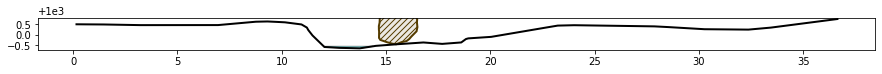

In [29]:
## Enter WSE
plot_metrics(999.45)
#plt.savefig("practice_output4.jpg", bbox_inches ='tight', dpi = 300)

In [27]:
flow_area_interstitial = 4
wood_sub_area = 0

def conveyance_ratio(flow_area_interstitial, wood_sub_area):
    return flow_area_interstitial / wood_sub_area if wood_sub_area else 'nan'
    
    #conveyance_ratio =  conveyance_ratio() # CONVEYANCE RATIO (actual flow area over frontal area of LW)

print(conveyance_ratio(flow_area_interstitial, wood_sub_area))

nan
